# Variational AutoEncoder (VAE)

The VAE implemented in this tutorial is based on the following idea: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details. However, we are going to use MSE.

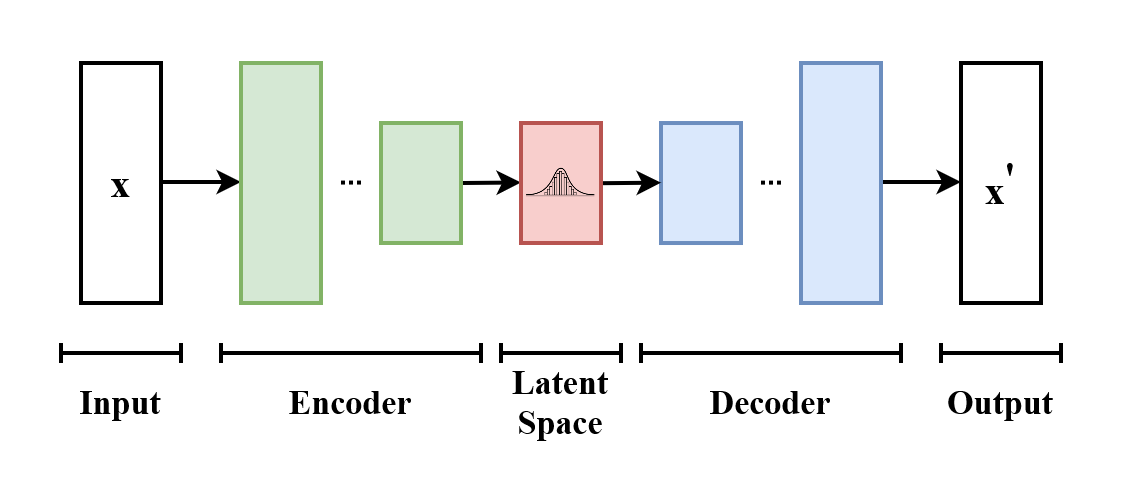
[Source of the picture](https://en.wikipedia.org/wiki/Autoencoder#/media/File:VAE_Basic.png)

In [ ]:
import os

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.utils as vutils
from torchvision import datasets
from torchvision.utils import make_grid
from tqdm import tqdm_notebook as tqdm

plt.ion()

## Load (or download) Dataset

In [ ]:
!wget https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip

In [ ]:
!unzip img_align_celeba.zip -d data

In [ ]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Define our model


In its original form, VAEs sample from a random node $z$ which is approximated by the parametric model $q(z∣ϕ,x)$ of the true posterior. Backprop cannot flow through a random node.

Introducing a new parameter $\epsilon$ allows us to reparameterize $z$ in a way that allows backprop to flow through the deterministic nodes.

![](https://miro.medium.com/max/1400/1*ZlzFeen0J7Ize__drfbwOQ.webp)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

In [ ]:
class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar

    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, size):
        sample = torch.randn(size, self.nz).to(self.device)
        return model.decode(sample)

    @property
    def device(self): return next(self.parameters()).device

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Define Loss function

The regularity that is expected from the latent space in order to make generative process possible can be expressed through two main properties: continuity (two close points in the latent space should not give two completely different contents once decoded) and completeness (for a chosen distribution, a point sampled from the latent space should give “meaningful” content once decoded).

![](https://machinelearningmastery.ru/img/0-609638-740406.png)

The only fact that VAEs encode inputs as distributions instead of simple points is not sufficient to ensure continuity and completeness. Without a well defined regularisation term, the model can learn, in order to minimise its reconstruction error, to “ignore” the fact that distributions are returned and behave almost like classic autoencoders (leading to overfitting). We have to regularise both the covariance matrix and the mean of the distributions returned by the encoder. In practice, this regularisation is done by enforcing distributions to be close to a standard normal distribution (centred and reduced). This way, we require the covariance matrices to be close to the identity, preventing punctual distributions, and the mean to be close to 0, preventing encoded distributions to be too far apart from each others.

![](https://machinelearningmastery.ru/img/0-957522-896652.png)

The parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss that helps learn well-formed latent spaces and reduce overfitting to the training data.

$$L = \int_zq(z)log(p(x|\Theta,z))dz - KL(q(z)||p(z))$$

$$p(z)=\mathcal{N}(0,1)$$
$$q(z)=\mathcal{N}(\mu_1,\Sigma_1) , \Sigma_1 \text{is diagonal matrix.}$$


$${KL}[\mathcal{N}(\mu_0, \Sigma_0)||\mathcal{N}(\mu_1, \Sigma_1)] = \frac{1}{2}\big(tr(\Sigma_1^{-1}\Sigma_0)+(\mu_1-\mu_0)^T\Sigma_1^{-1}(\mu_1-\mu_0)-k+\log(\frac{\det\Sigma_1}{\det\Sigma_0})\big)$$

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

In [ ]:
epochs=1

def train(pbar):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        loss.backward()
        train_loss += loss.item();
        train_mse += mse_loss.item(); train_kld += kld_loss.item()
        optimizer.step()
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
    for epoch in range(1, epochs + 1):
        train(pbar)


In [ ]:
model.eval()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[:50], 10, 5, normalize=True).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

In [ ]:
images, labels = next(iter(dataloader))

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title('Original images')
show_image(torchvision.utils.make_grid(images[:64],padding=5, normalize=True))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("VAE reconstruction")
images = images.to(device)
images, _, _ = model(images)
images = images.cpu()
show_image(torchvision.utils.make_grid(images[:64], padding=5, normalize=True))

# Latent Space Arithmetics

In [ ]:
def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device).view(-1, 3, 64, 64)
        latent_1 = model.encode(img1)

        # latent vector of second image
        img2 = img2.to(device).view(-1, 3, 64, 64)
        latent_2 = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

In [ ]:
# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), model, real_batch[0][0], real_batch[0][1])
    inter_image = to_img(inter_image)


    axs[ind].imshow(np.transpose(inter_image[0], (1, 2, 0)))
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off');

In [ ]:
with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, 100, device=device)

    # reconstruct images from the latent vectors
    img_recon = model.decode(latent)
    img_recon = img_recon.cpu().reshape(-1, 3, 64, 64)

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5, normalize=True))
    plt.axis('off')

In [ ]:
n_features = 10

with torch.no_grad():

    # create a sample grid in latent space
    sample = np.random.normal(size = (100))

    latent_x = np.linspace(-2,2,10)
    latent_y = np.linspace(-2,2,10)

    latents = torch.FloatTensor(len(latent_y), len(latent_x), 100)

    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i,] = torch.from_numpy(sample)
            for z in range(n_features):
                latents[j, i, 2 * z] = lx
                latents[j, i, 2 * z + 1] = ly

    latents = latents.view(-1, 100) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = model.decode(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data,10,5, normalize=True))
    plt.axis('off')
    plt.show()